# **Install the Required Libraries**

In [1]:
%%capture
!pip install langchain
!pip install langchain-google-genai
!pip install langchain-community
!pip install langchain-chroma
!pip install langchain-core
!pip install langgraph
!pip install PyMuPDF
!pip install chromadb

# **Load the Required API Keys**

In [1]:
#Set up Gemini & Tavily Search API keys
import os
import yaml

with open("gemini_key_gtm.yaml", 'r') as file:
    api_creds = yaml.safe_load(file)

os.environ["GOOGLE_API_KEY"] = api_creds['gemini_key']

with open("tavily_key.yaml", 'r') as file:
    api_creds = yaml.safe_load(file)

os.environ["TAVILY_API_KEY"] = api_creds['tavily_key']
Tavily_API_Key = os.environ["TAVILY_API_KEY"]

# **Import Required Libraries**

In [2]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_chroma import Chroma
from langchain_google_genai import ChatGoogleGenerativeAI, GoogleGenerativeAIEmbeddings
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_community.document_loaders import PyMuPDFLoader
from langchain_core.output_parsers import StrOutputParser
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain.schema import Document
from langgraph.graph import END, StateGraph
from IPython.display import Image, display, Markdown
from operator import itemgetter
from typing import List
from typing_extensions import TypedDict
import tempfile
import os

/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py:3553: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


# **Define the Language Model & Embedding Model**

In [3]:
embed_model = GoogleGenerativeAIEmbeddings(model="models/text-embedding-004")
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash")

# **Load & Chunk the Document**

In [4]:
files = "/content/practitioners_guide_to_mlops_whitepaper.pdf"

loader = PyMuPDFLoader(files)
docs = loader.load()
splitter = RecursiveCharacterTextSplitter(chunk_size=2000, chunk_overlap=300)
chunked_docs = splitter.split_documents(docs)

In [5]:
len(chunked_docs)

51

In [6]:
chunked_docs[:3]

[Document(metadata={'producer': 'Adobe PDF Library 15.0', 'creator': 'Adobe InDesign 16.1 (Macintosh)', 'creationdate': '2021-05-11T22:05:38+03:00', 'source': '/content/practitioners_guide_to_mlops_whitepaper.pdf', 'file_path': '/content/practitioners_guide_to_mlops_whitepaper.pdf', 'total_pages': 37, 'format': 'PDF 1.7', 'title': '', 'author': '', 'subject': '', 'keywords': '', 'moddate': '2021-05-11T22:05:50+03:00', 'trapped': '', 'modDate': "D:20210511220550+03'00'", 'creationDate': "D:20210511220538+03'00'", 'page': 0}, page_content='Practitioners guide to MLOps:\nA framework for continuous \ndelivery and automation of\nmachine learning.\nWhite paper\nMay 2021\nAuthors:\nKhalid Salama,\nJarek Kazmierczak,\nDonna Schut'),
 Document(metadata={'producer': 'Adobe PDF Library 15.0', 'creator': 'Adobe InDesign 16.1 (Macintosh)', 'creationdate': '2021-05-11T22:05:38+03:00', 'source': '/content/practitioners_guide_to_mlops_whitepaper.pdf', 'file_path': '/content/practitioners_guide_to_mlop

# **Define the Chroma Vector Database**

In [7]:
# Create Chroma Vector DB
chroma_db = Chroma.from_documents(
    documents=chunked_docs,
    collection_name='rag_db',
    embedding=embed_model,
    collection_metadata={"hnsw:space": "cosine"},
    persist_directory="./doc_db"
)

# **Define the Retriever**

In [8]:
similarity_threshold_retriever = chroma_db.as_retriever(search_type="similarity_score_threshold",
                                                        search_kwargs={"k": 3,
                                                                       "score_threshold": 0.3})

In [9]:
query = "what is the mlops?"
retrieved_docs = similarity_threshold_retriever.invoke(query)
retrieved_docs

[Document(id='d69e1483-8c75-4b32-af45-e6ccda0281d7', metadata={'author': '', 'creationDate': "D:20210511220538+03'00'", 'creationdate': '2021-05-11T22:05:38+03:00', 'creator': 'Adobe InDesign 16.1 (Macintosh)', 'file_path': '/content/practitioners_guide_to_mlops_whitepaper.pdf', 'format': 'PDF 1.7', 'keywords': '', 'modDate': "D:20210511220550+03'00'", 'moddate': '2021-05-11T22:05:50+03:00', 'page': 2, 'producer': 'Adobe PDF Library 15.0', 'source': '/content/practitioners_guide_to_mlops_whitepaper.pdf', 'subject': '', 'title': '', 'total_pages': 37, 'trapped': ''}, page_content='framework can help organizations improve collaboration between teams, improve the reliability and scalability of ML \nsystems, and shorten development cycle times. These benefits in turn drive innovation and help gain overall busi\xad\nness value from investments in ML.\nThis document is intended for technology leaders and enterprise architects who want to understand MLOps. It’s also \nfor teams who want detai

In [10]:
query = "what is llmops?"
retrieved_docs = similarity_threshold_retriever.invoke(query)
retrieved_docs

[Document(id='77604f6f-2ca2-46ad-85c9-080566f309d4', metadata={'author': '', 'creationDate': "D:20210511220538+03'00'", 'creationdate': '2021-05-11T22:05:38+03:00', 'creator': 'Adobe InDesign 16.1 (Macintosh)', 'file_path': '/content/practitioners_guide_to_mlops_whitepaper.pdf', 'format': 'PDF 1.7', 'keywords': '', 'modDate': "D:20210511220550+03'00'", 'moddate': '2021-05-11T22:05:50+03:00', 'page': 2, 'producer': 'Adobe PDF Library 15.0', 'source': '/content/practitioners_guide_to_mlops_whitepaper.pdf', 'subject': '', 'title': '', 'total_pages': 37, 'trapped': ''}, page_content='framework can help organizations improve collaboration between teams, improve the reliability and scalability of ML \nsystems, and shorten development cycle times. These benefits in turn drive innovation and help gain overall busi\xad\nness value from investments in ML.\nThis document is intended for technology leaders and enterprise architects who want to understand MLOps. It’s also \nfor teams who want detai

# **Create a Query Retrieval Grader**

In [11]:
# Data model for LLM output format
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""
    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )


structured_llm_grader = llm.with_structured_output(GradeDocuments)

# Prompt template for grading
SYS_PROMPT = """You are an expert grader assessing relevance of a retrieved document to a user question.
                Follow these instructions for grading:
                  - If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant.
                  - Your grade should be either 'yes' or 'no' to indicate whether the document is relevant to the question or not.
             """

grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", SYS_PROMPT),
        ("human", """Retrieved document:
                     {document}
                     User question:
                     {question}
                  """),
    ]
)
# Build grader chain
doc_grader = (grade_prompt
                  |
              structured_llm_grader)

In [31]:
query = "what is the mlops and its lifecycle?"
top3_docs = similarity_threshold_retriever.invoke(query)
for doc in top3_docs:
    print(doc.page_content)
    print('GRADE:', doc_grader.invoke({"question": query, "document": doc.page_content}))
    print()

7
The MLOps lifecycle
The MLOps lifecycle encompasses seven integrated and iterative processes, as shown in figure 2.
The processes can consist of the following:
•	
ML development concerns experimenting and developing a robust and reproducible model training proce­
dure (training pipeline code), which consists of multiple tasks from data preparation and transformation to 
model training and evaluation.
•	
Training operationalization concerns automating the process of packaging, testing, and deploying repeat­
able and reliable training pipelines.
•	
Continuous training concerns repeatedly executing the training pipeline in response to new data or to code 
changes, or on a schedule, potentially with new training settings.
•	
Model deployment concerns packaging, testing, and deploying a model to a serving environment for online 
experimentation and production serving.
Figure 2. The MLOps lifecycle
GRADE: binary_score='yes'

7
The MLOps lifecycle
The MLOps lifecycle encompasses seven integ

In [30]:
query = "what is the llmops"
top3_docs = similarity_threshold_retriever.invoke(query)
for doc in top3_docs:
    print(doc.page_content)
    print('GRADE:', doc_grader.invoke({"question": query, "document": doc.page_content}))
    print()

framework can help organizations improve collaboration between teams, improve the reliability and scalability of ML 
systems, and shorten development cycle times. These benefits in turn drive innovation and help gain overall busi­
ness value from investments in ML.
This document is intended for technology leaders and enterprise architects who want to understand MLOps. It’s also 
for teams who want details about what MLOps looks like in practice. The document assumes that readers are famil­
iar with basic machine learning concepts and with development and deployment practices such as CI/CD.
The document is in two parts. The first part, an overview of the MLOps lifecycle, is for all readers. It introduces 
MLOps processes and capabilities and why they’re important for successful adoption of ML-based systems.
The second part is a deep dive on the MLOps processes and capabilities. This part is for readers who want to un­
derstand the concrete details of tasks like running a continuous trai

# **Build a QA RAG Chain**

In [12]:
prompt = """You are an assistant for question-answering tasks.
            Use the following pieces of retrieved context to answer the question.
            If no context is present or if you don't know the answer, just say that you don't know the answer.
            Do not make up the answer unless it is there in the provided context.
            Give a detailed answer and to the point answer with regard to the question.
            Question:
            {question}
            Context:
            {context}
            Answer:
         """

prompt_template = ChatPromptTemplate.from_template(prompt)

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

qa_rag_chain = (
    {
        "context": (itemgetter('context')
                        |
                    RunnableLambda(format_docs)),
        "question": itemgetter('question')
    }
      |
    prompt_template
      |
    llm
      |
    StrOutputParser()
)

# **Create a Query Rephraser**

In [13]:
# Prompt template for rewriting
SYS_PROMPT = """Act as a question re-writer and perform the following task:
                 - Convert the following input question to a better version that is optimized for web search.
                 - When re-writing, look at the input question and try to reason about the underlying semantic intent / meaning.
             """

re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", SYS_PROMPT),
        ("human", """Here is the initial question:
                     {question}
                     Formulate an improved question.
                  """,
        ),
    ]
)

question_rewriter = (re_write_prompt
                        |
                       llm
                        |
                     StrOutputParser())

In [14]:
query = "what is the difference between mlops vs llmops?"
question_rewriter.invoke({"question": query})

'MLOps vs. LLMOps: Key Differences and Comparison'

# **Define the Tavily Web Search**

In [15]:
tv_search = TavilySearchResults(max_results=3, search_depth='advanced',
                                max_tokens=10000)

# **Graph State**

stores and represent the state of the agent graph as we traverse through various nodes

In [16]:
class GraphState(TypedDict):
    """
    Represents the state of our graph.
    Attributes:
        question: question
        generation: LLM response generation
        web_search_needed: flag of whether to add web search - yes or no
        documents: list of context documents
    """

    question: str
    generation: str
    web_search_needed: str
    documents: List[str]

# **Retrieve**

retrieves the relevant context documents from the vector database.

In [17]:
def retrieve(state):
    """
    Retrieve documents
    Args:
        state (dict): The current graph state
    Returns:
        state (dict): New key added to state, documents - that contains retrieved context documents
    """
    print("---RETRIEVAL FROM VECTOR DB---")

    question = state["question"]

    # Retrieval
    documents = similarity_threshold_retriever.invoke(question)

    return {"documents": documents, "question": question}

# **Grade Documents**

checks whether the retrieved documents are relevant to the question by using an LLM Grader

In [18]:
def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question
    by using an LLM Grader.
    If any document are not relevant to question or documents are empty - Web Search needs to be done
    If all documents are relevant to question - Web Search is not needed
    Helps filtering out irrelevant documents
    Args:
        state (dict): The current graph state
    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """
    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")

    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    web_search_needed = "No"

    if documents:
        for d in documents:
            score = doc_grader.invoke(
                {"question": question, "document": d.page_content}
            )
            grade = score.binary_score
            if grade == "yes":
                print("---GRADE: DOCUMENT RELEVANT---")
                filtered_docs.append(d)
            else:
                print("---GRADE: DOCUMENT NOT RELEVANT---")
                web_search_needed = "Yes"
                continue
    else:
        print("---NO DOCUMENTS RETRIEVED---")
        web_search_needed = "Yes"

    return {"documents": filtered_docs, "question": question, "web_search_needed": web_search_needed}

# **Query Rewriter**

rewrites the input query to produce a better question optimized for web search using an LLM

In [19]:
def rewrite_query(state):
    """
    Rewrite the query to produce a better question.
    Args:
        state (dict): The current graph state
    Returns:
        state (dict): Updates question key with a re-phrased or re-written question
    """
    print("---REWRITE QUERY---")

    question = state["question"]
    documents = state["documents"]

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})

    return {"documents": documents, "question": better_question}

# **Web Search**

searches the web using the web search tool for the given query and retrieve some information which can be used as the context in RAG.

In [20]:
def web_search(state):
    """
    Web search based on the re-written question.
    Args:
        state (dict): The current graph state
    Returns:
        state (dict): Updates documents key with appended web results
    """
    print("---WEB SEARCH---")

    question = state["question"]
    documents = state["documents"]

    # Web search
    docs = tv_search.invoke(question)
    web_results = "\n\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)
    documents.append(web_results)

    return {"documents": documents, "question": question}

# **Generate Answer**

Response generation from query and context documents.

In [21]:
def generate_answer(state):
    """
    Generate answer from context document using LLM
    Args:
        state (dict): The current graph state
    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE ANSWER---")

    question = state["question"]
    documents = state["documents"]

    # RAG generation
    generation = qa_rag_chain.invoke({"context": documents, "question": question})

    return {"documents": documents, "question": question, "generation": generation}

# **Decide to Generate**

checks if a web search is needed or a response should be generated.

In [22]:
def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.
    Args:
        state (dict): The current graph state
    Returns:
        str: Binary decision for next node to call
    """
    print("---ASSESS GRADED DOCUMENTS---")

    web_search_needed = state["web_search_needed"]

    if web_search_needed == "Yes":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print("---DECISION: SOME or ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, REWRITE QUERY---")
        return "rewrite_query"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE RESPONSE---")
        return "generate_answer"

# **Agent Graph**

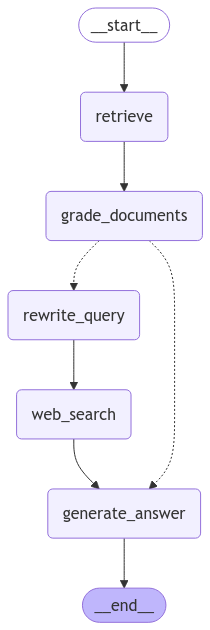

In [23]:
agentic_rag = StateGraph(GraphState)

# Define the nodes
agentic_rag.add_node("retrieve", retrieve)  # retrieve
agentic_rag.add_node("grade_documents", grade_documents)  # grade documents
agentic_rag.add_node("rewrite_query", rewrite_query)  # transform_query
agentic_rag.add_node("web_search", web_search)  # web search
agentic_rag.add_node("generate_answer", generate_answer)  # generate answer

# Build graph
agentic_rag.set_entry_point("retrieve")
agentic_rag.add_edge("retrieve", "grade_documents")
agentic_rag.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {"rewrite_query": "rewrite_query", "generate_answer": "generate_answer"},
)
agentic_rag.add_edge("rewrite_query", "web_search")
agentic_rag.add_edge("web_search", "generate_answer")
agentic_rag.add_edge("generate_answer", END)

# Compile
agentic_rag = agentic_rag.compile()

#Display the Graph
display(Image(agentic_rag.get_graph().draw_mermaid_png()))

# **Test the Agentic CRAG System**

In [26]:
query = "what is the difference between mlops vs llmops?"
response = agentic_rag.invoke({"question": query})
display(Markdown(response['generation']))

---RETRIEVAL FROM VECTOR DB---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: SOME or ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, REWRITE QUERY---
---REWRITE QUERY---
---WEB SEARCH---
---GENERATE ANSWER---


LLMOps extends MLOps by incorporating practices specific to large language models (LLMs).  While MLOps covers a broader range of machine learning model management tasks, LLMOps focuses specifically on the deployment and management of LLMs.  Key differences include an increased emphasis on prompt engineering and fine-tuning during experimentation, rather than feature engineering, which is less crucial due to LLMs' ability to learn feature representations from raw data.  The ultimate goal of LLMOps is to enable the rapid, streamlined, automated, and ethical deployment of LLMs into production environments.